In [3]:
import numpy as np

from scipy import linalg
from scipy import special
from scipy import sparse
from scipy.sparse import linalg as sparse_linalg

from matplotlib import pyplot as plt

from copy import deepcopy

from functools import reduce

In [2]:
import unittest
import sys

## **Procedure to compute** $U_1, \dots, U_l$

**Comment** \[Input to this procedure consists of the number of points $n$, the number of zero moments $k$, and the points $x_1, \dots, x_n$. Output is the matrices $U_{j,i}$ for $j = 1, \dots, l$ and $\displaystyle i = l, \dots, \frac{n}{2^jk}$, which make up the matrices $U_1, \dots, U_l$ (note $\displaystyle l = \log_2 \left( \frac{n}{k} \right)$).\]

<h2 style="text-align: center; font-weight: bold;"> Step 1. </h2>

Compute the shifted and scaled moments matrices $M'_{1,i}$ for $\displaystyle i = 1, \dots, \frac{n}{2k}$.

__Alexandre Comment:__

* In the text $j$ ranges from $1$ to $l$, in the code it'll range from $0$ to $l-1$.
* In the text $i$ ranges from $1$ to $\displaystyle \frac{n}{k 2^j}$, in the code it'll range from $0$ to $\displaystyle \frac{n}{k 2^j} - 1$.
* There's a compensation for the fact that - besides $i$ and $j$ starting in $0$ instead of $1$ - `xs` is indexed starting in $0$.

##### Formulae for step 1:

| Symbol   | Text definition &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Implementation &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;|
|:---------|:---------------------------------------------------|:---------------------------------------------------------------|
| $\mu$    | $\mu_{j,i} = x_{1 + (i-1) k 2^j} + x_{i k 2^j}$    | $\mu_{j,i} = x_{i k 2^{(j+1)}} + x_{(i+1) k 2^{(j+1)} - 1}$    |
| $\sigma$ | $\sigma_{j,i} = x_{i k 2^j} - x_{1 + (i-1) k 2^j}$ | $\sigma_{j,i} = x_{(i+1) k 2^{(j+1)} - 1} - x_{i k 2^{(j+1)}}$ |
| $s$      | $s_i = (i-1) 2k$                                   | $s_i = i 2 k$                                                  |

##### What about the `_builder()` functions?

__Short version:__ I'm trying to respect the D.R.Y. (Don't Repeat Yourself) principle when passing the arguments.

__Complementing the short version:__ it's easy to write higher order functions in Python and I wanted the function calls to look like the text as much as possible. But I wanted other two features to my code, besides being readable:
1. it should avoid side effects (it helps to look more mathematical)
2. neither "mathematicality" nor readability should be given up for the sake of the other

In [3]:
def mu_builder (xs, k):
    def mu (j, i):
        idx = ( i*k*2**(j+1), (i+1)*k*2**(j+1)-1 )
        return ( xs[ idx[0] ] + xs[ idx[1] ] ) / 2
    
    return mu

def sigma_builder (xs, k):
    def sigma (j, i):
        idx = ( (i+1)*k*2**(j+1)-1, i*k*2**(j+1) )
        return ( xs[ idx[0] ] - xs[ idx[1] ] ) / 2
    
    return sigma

def s_builder (k):
    def s (i):
        return i*2*k
    
    return s

In [4]:
def shifted_scaled_matrices (xs, k, l): # M'0,i
    '''First row of the matrix of shifted scaled moments matrices'''
    n = len(xs)
    assert n % (2*k) == 0
    
    mu = mu_builder(xs, k)
    sigma = sigma_builder(xs, k)
    s = s_builder(k)
    
    Ms = []
    for i in range(n//(2*k)): # matrices loop
        s_i = s(i)
        mu_0_i = mu(0,i)
        sigma_0_i = sigma(0,i)
        
        M = np.ones((2*k,2*k))
        for r in range(2*k): # rows loop
            for c in range(1,2*k): # entries loop
                M[r,c] = ( (xs[s_i + r] - mu_0_i) / sigma_0_i )**c
        
        Ms.append( deepcopy(M) )
    
    return Ms

<h2 style="text-align: center; font-weight: bold;">Step 2.</h2>

Compute $U_{1,i}$ from $M'_{1,i}$ by Eq. (4.11) using Gram-Schmidt (?) orthogonalization for $i = 1,\dots, \frac{n}{2k}$.

In [5]:
def U_j_i (M_j_i):
    return linalg.qr(M_j_i)[0].T

<h2 style="text-align: center; font-weight: bold;">Step 3.</h2>

**Comment** \[Compute $M'_{j,i}$ and $U_{j,i}$ for $j = 2, \dots, l$ and $\displaystyle i = 1, \dots, \frac{n}{2^jk}$\.]

<!-- Seja M uma matriz m x n, M^U é a matriz m/2 x n formada pelas m/2 primeiras linhas de M -->
<!-- Seja M uma matriz m x n, M^L é a matriz m/2 x n formada pelas m/2 últimas linhas de M -->

<img src="step-3_algorithm.jpg">

<!--
```
do j = 2, ..., l
    do i = 1, ..., n/(2^j*k)
        Compute U_j-1,2i-1^U M'_j-1,2i-1 and U_j-1,2i^U M'_j-1,2i.
        Compute S^1_j,i by Eq. (4.16) and S^2_j,i by Eq. (4.17);
            multiply to obtain M'_j,i by Eq. (4.13).
        Orthogonalize M'_j,i to obtain U_j,i by Eq. (4.11).
    enddo
enddo
```
-->

In [6]:
def upper_half_rows (matrix):
    rows = matrix.shape[0] # checks if there's an even number of rows
    assert rows % 2 == 0
    
    return matrix[:rows//2, :]

def lower_half_rows (matrix):
    rows = matrix.shape[0] # checks if there's an even number of rows
    assert rows % 2 == 0
    
    return matrix[rows//2:, :]

__Alexandre Comment:__

It's necessary to make some compensations to the indices for defining $S^1_{j,i}$ and $S^2_{j,i}$. I've observed that: 
1. the $j$ index starts at the second possible position; and 
2. the $i$ index iterate through all possible indices.

The way I've written the functions for $\mu$ and $\sigma$ require some adaptions to make the $i$ index start where it should, even though I'm starting at $0$ instead of $1$. My solutions for this problem are resumed in the table below.

##### Formulae for $S^1$ and $S^2$:

| Symbol   | Text definition &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| Implementation &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;|
|:---------|:---------------------------------------------------|:---------------------------------------------------------------|
| $S^1$ | $\displaystyle S^1_{j,i} = S \biggl( \biggl( \frac{\mu_{j,i} - \mu_{j-1,2i-1}}{\sigma_{j-1,2i-1}} \biggr), \frac{\sigma_{j,i}}{\sigma_{j-1,2i-1}} \biggr)$ | $\displaystyle S^1_{j,i} = S \biggl( \biggl( \frac{\mu_{j,i} - \mu_{j-1,2i}}{\sigma_{j-1,2i}} \biggr), \frac{\sigma_{j,i}}{\sigma_{j-1,2i}} \biggr)$ |
| $S^2$ | $\displaystyle S^2_{j,i} = S \biggl( \biggl( \frac{\mu_{j,i} - \mu_{j-1,2i}}{\sigma_{j-1,2i}} \biggr), \frac{\sigma_{j,i}}{\sigma_{j-1,2i}} \biggr)$ | $\displaystyle S^2_{j,i} = S \biggl( \biggl( \frac{\mu_{j,i} - \mu_{j-1,2i+1}}{\sigma_{j-1,2i+1}} \biggr), \frac{\sigma_{j,i}}{\sigma_{j-1,2i+1}} \biggr)$ |

In [7]:
def shift_scale_matrix_builder (xs, k):
    def shift_scale_matrix (mu_value, sigma_value): # S(μ,σ)
        return np.array([
            [ special.binom(j, i)*(-mu_value)**(j-i)/sigma_value**j for j in range(2*k) ] for i in range(2*k)
        ])
    
    return shift_scale_matrix

def shift_scale_upper_builder (xs, k, mu=None, sigma=None):
    '''Builder function shift-scale matrix (S¹) for the upper half of the M' matrix'''
    if mu is None:
        mu = mu_builder(xs, k)
    
    if sigma is None:
        sigma = sigma_builder(xs, k)
    
    S = shift_scale_matrix_builder(xs, k)
    
    def shift_scale_upper (j, i):
        '''Shift-scale (S¹) matrix for the upper half of the M' matrix'''
        # this indices (j, i) are not the entries of the matrix
        # instead those denote a matrix in a bidimensional collection of matrices
        m = (mu(j, i) - mu(j-1, 2*i)) / sigma(j-1, 2*i)
        s = sigma(j, i) / sigma(j-1, 2*i)
        
        return S(m, s)
    
    return shift_scale_upper

def shift_scale_lower_builder (xs, k, mu=None, sigma=None):
    '''Builder function shift-scale matrix (S²) for the lower half of the M' matrix'''
    if mu is None:
        mu = mu_builder(xs, k)
    
    if sigma is None:
        sigma = sigma_builder(xs, k)
    
    S = shift_scale_matrix_builder(xs, k)
    
    def shift_scale_lower (j, i):
        '''Shift-scale matrix (S²) for the lower half of the M' matrix'''
        # this indices (j, i) are not the entries of the matrix
        # instead those denote a matrix in a bidimensional collection of matrices
        m = (mu(j, i) - mu(j-1, 2*i+1)) / sigma(j-1, 2*i+1)
        s = sigma(j, i) / sigma(j-1, 2*i+1)
        
        return S(m, s)
    
    return shift_scale_lower

In [8]:
def n_j_builder (n, k):
    def n_j (j):
        return n // (2**(j+1)*k)
    
    return n_j

In [9]:
def orth_moments_matrices_builder (xs, k): # all Uj,i
    n = len(xs)
    assert n % (2*k) == 0
    
    l = int( np.log2(n/k) )
    
    mu = mu_builder(xs, k)
    sigma = sigma_builder(xs, k)
    
    S_1 = shift_scale_upper_builder(xs, k, mu=mu, sigma=sigma)
    S_2 = shift_scale_lower_builder(xs, k, mu=mu, sigma=sigma)
    
    n_ = n_j_builder(n, k)
    
    def orth_moments_matrices (M_1s):
        Ms_prev = deepcopy(M_1s)
        Us = [ [ linalg.qr(M)[0].T for M in Ms_prev ] ]
        for j in range(1,l):
            nj = n_(j)
            Ms_current = []
            Us.append([])
            
            for i in range( nj ):
                M_upper_half = upper_half_rows( Us[j-1][2*i] ) @ Ms_prev[2*i] @ S_1(j,i)
                M_lower_half = upper_half_rows( Us[j-1][2*i+1] ) @ Ms_prev[2*i+1] @ S_2(j,i)
                
                rows, columns = M_upper_half.shape
                
                M = np.empty( (2*rows, columns) )
                M[:rows, :] = M_upper_half
                M[rows:, :] = M_lower_half
                
                Ms_current.append( deepcopy(M) )
            
            Us[j] += [ linalg.qr(M)[0].T for M in Ms_current ]
        
        return Us
    
    return orth_moments_matrices

In [10]:
def basis_matrices_builder (n, k, l): # U_j
    n_ = n_j_builder(n, k)
    
    def basis_matrix (U_j_is, j):
        U = U_j_is
        nj = n_(j)
        U_prime_j = sparse.lil_matrix( (2*k*nj, 2*k*nj) )
        
        for i in range(nj):
            row, row_next = i*k, (i + 1)*k
            col, col_next = 2*row, 2*row_next
            
            U_prime_j[row:row_next, col:col_next] = lower_half_rows(U[j][i])
            
            row, row_next = row + n//2**(j+1), row_next + n//2**(j+1)
            
            U_prime_j[row:row_next, col:col_next] = upper_half_rows(U[j][i])
        
        if j == 0:
            Uj = U_prime_j
        else:
            Uj = sparse.lil_matrix( (n,n) )
            Uj[:n-n//2**j, :n-n//2**j] = sparse.eye(n-n//2**j)
            Uj[n-n//2**j:, n-n//2**j:] = U_prime_j
        
        return sparse.lil_matrix(Uj)
    
    def basis_matrices (U_j_is):
        return [ basis_matrix(U_j_is, j) for j in range(l) ]
    
    return basis_matrices

## Visualization of $U_j$ matrices

Below a plot of the $U_j$ matrices for $j=0,\dots,l-1$.

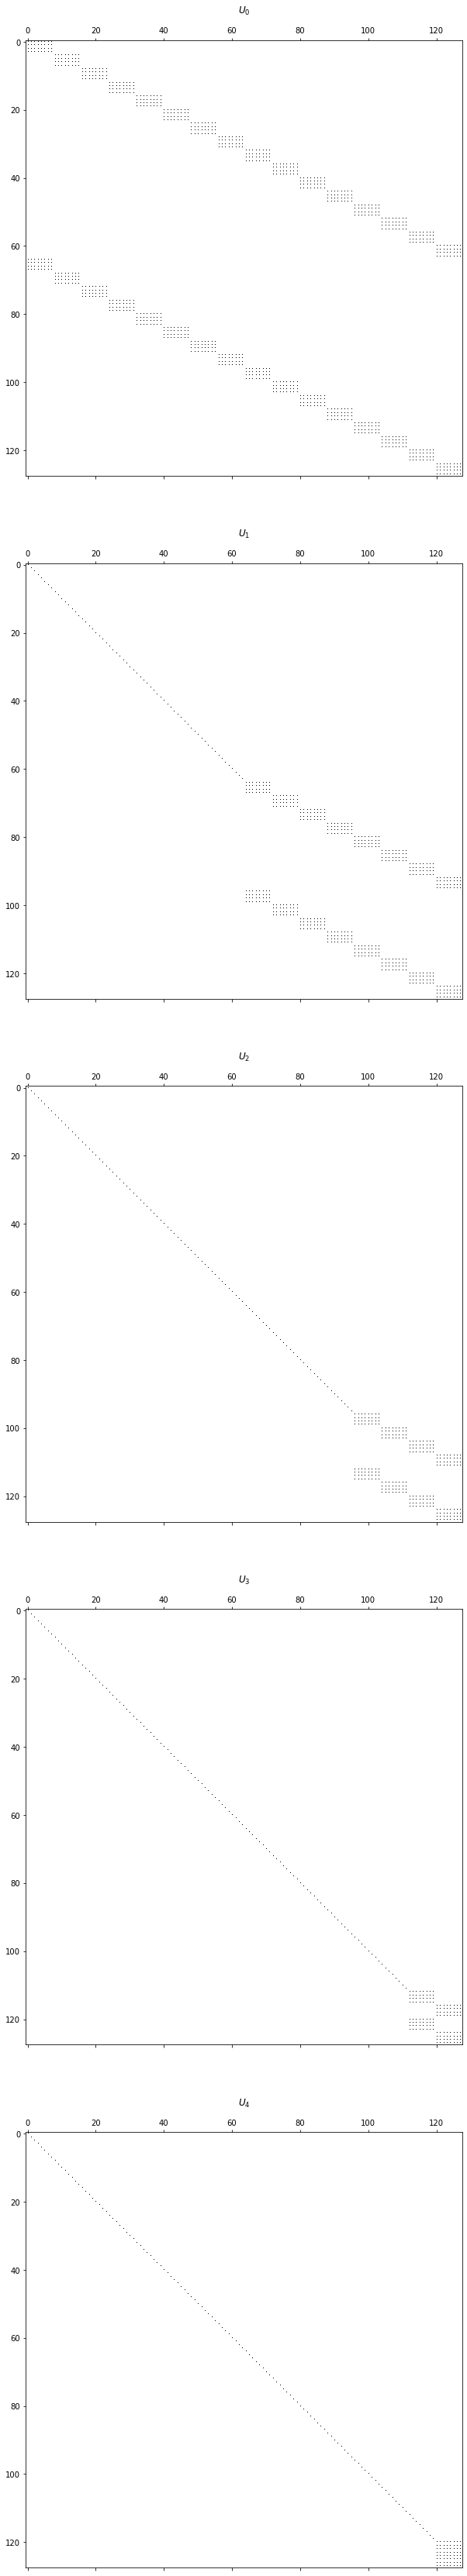

In [11]:
n, k, l = 128, 4, 5
xs = np.linspace(0, 1, n)

M_1s = shifted_scaled_matrices(xs, k, l)

U_j_is_ = orth_moments_matrices_builder(xs, k)
U_j_is = U_j_is_(M_1s)

Us_ = basis_matrices_builder(n, k, l)
Us = Us_(U_j_is)

fig = plt.figure('Uj_matrices', figsize=(len(Us)*12, len(Us)*12))

for j in range(l):
    ax = fig.add_subplot(len(Us), 1, j+1)
    
    ax.set_title('$U_{}$'.format(j))
    ax.spy(Us[j], marker=',', color='black')
    
plt.show()

## **Procedure to compute** $UTU^T$

**Comment** [Input to this procedure consists of $n, k$, the matrices $U_{j,i}$ computed above, a function to compute elements of $T$, and the chosen precision $\varepsilon$. Output is a matrix $R_l$ such that $\lVert R_l - UTU^T \rVert \lt \varepsilon \lVert T \rVert $.]

<h5 style="text-align: center; font-weight: bold;">Step 4.</h5>

Compute the $k \times k$ extracts, indicated by Eq. (4.18), of the submatrices of $T$ shown in Fig. 4.4.

<img src="fig_4.4.jpg" style="width: 70%;">

In [12]:
# calculate matrix T, K is a kernel function with 2 arguments
def trapezoidal_matrix (xs, K):
    n = len(xs)
    
    return np.array(
        [
            [ 0 if i == j else K(x_i, x_j)/(n-1) for j,x_j in enumerate(xs) ] 
            for i,x_i in enumerate(xs) 
        ]
    )

__Alexandre:__ This "either" in the image below may be wrong, probably the only right option is suplying a column to start in. The `extract_symmetric_block_diag()` function receives a matrix and outputs two matrices: 

* the first one is the original with zeros in the places from where the submatrices were extracted; 
* the second is the the matrix of the extracted submatrices

<!-- <img src="sym-block-diag.jpg" style="text-align:center" /> -->

In [13]:
def extract_symmetric_block_diag (M, index, block_size):
    assert isinstance(M, np.ndarray)
  
    rows, columns = M.shape
    assert rows == columns

    size = rows
    assert size >= index+block_size

    N = deepcopy(M)
    R = sparse.lil_matrix(N.shape)

    for j in range(index, size, block_size):
        i = j-index
        R[i:i+block_size, j:j+block_size] = N[i:i+block_size, j:j+block_size]
        N[i:i+block_size, j:j+block_size] = np.zeros( (block_size, block_size) )

        if i != j:
            R[j:j+block_size, i:i+block_size] = N[j:j+block_size, i:i+block_size]
            N[j:j+block_size, i:i+block_size] = np.zeros( (block_size, block_size) )
  
    return N, R

## Visualization of Block Extraction

Below is the plot that demonstrates how the `extract_symmetric_block_diag()` works. This function is necessary to decompose $T$ to $T_0, \dots, T_{l-1}$.

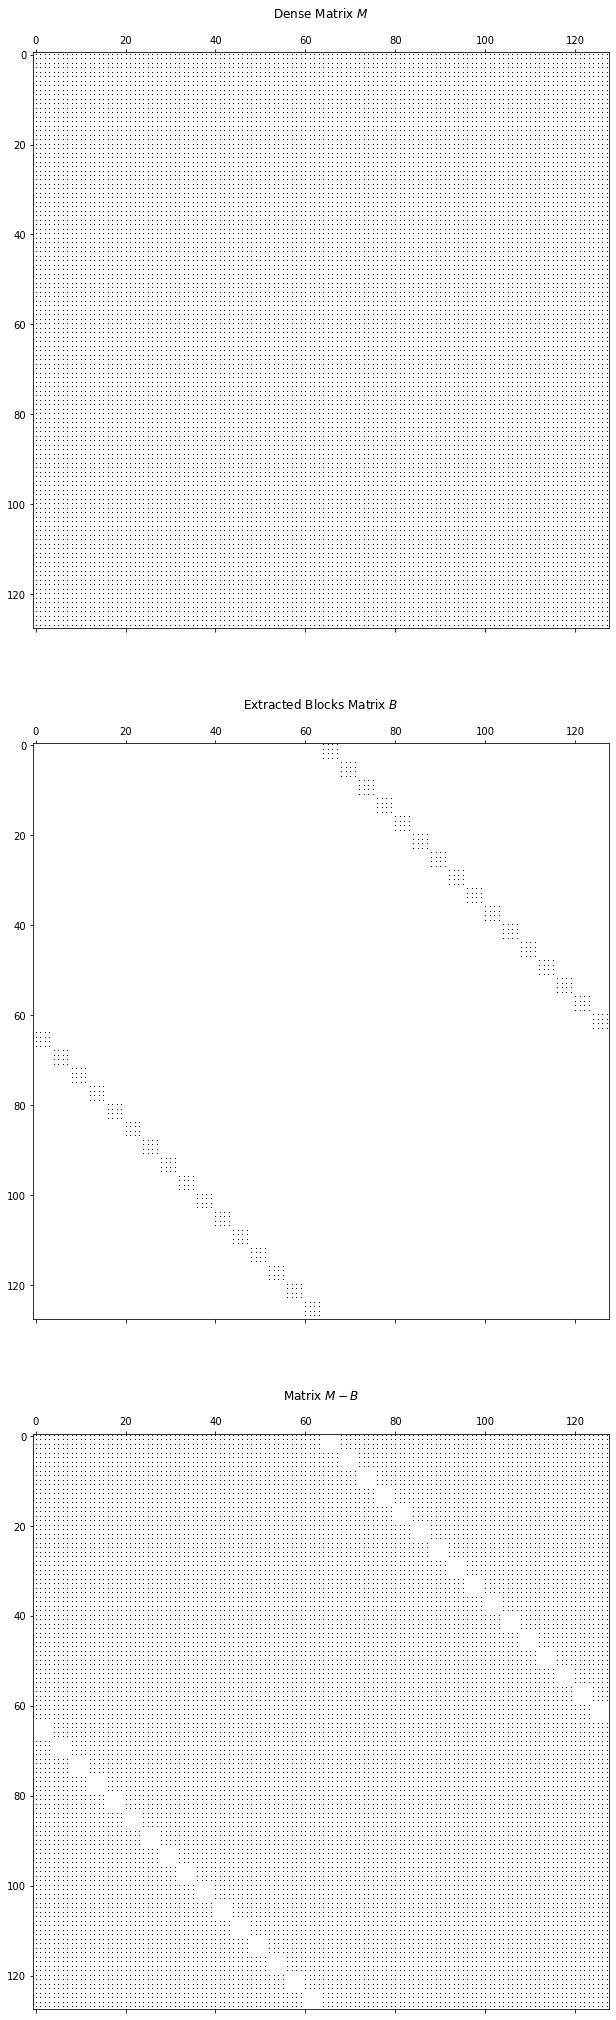

In [14]:
n, k = 128, 4
M = np.ones((n,n))
idx, block_size = n//2, k

not_B, B = extract_symmetric_block_diag(M, idx, block_size)

fig = plt.figure('symmetric_block_diag', figsize=(36, 36))

ax1 = fig.add_subplot(3, 1, 1)
ax1.set_title('Dense Matrix $M$')
ax1.spy(M, marker=',', color='black')

ax2 = fig.add_subplot(3, 1, 2)
ax2.set_title('Extracted Blocks Matrix $B$')
ax2.spy(B, marker=',', color='black')

ax3 = fig.add_subplot(3, 1, 3)
ax3.set_title('Matrix $M - B$')
ax3.spy(not_B, marker=',', color='black')

plt.show()

In [15]:
def submatrices_T (T, k, l):
    n = T.shape[0]

    block_sizes = ( 2**i*k for i in range(l-2,0,-1) )

    Ts = []

    T_0 = deepcopy(T)
    T_i = sparse.lil_matrix(T_0.shape)
    start_index = n
    
    for block_size in block_sizes:
        start_index -= block_size
        T_0, T_i_0 = extract_symmetric_block_diag(T_0, start_index, block_size)

        start_index -= block_size
        T_0, T_i_1 = extract_symmetric_block_diag(T_0, start_index, block_size)

        T_i = T_i_0 + T_i_1
        Ts = [deepcopy(T_i)] + Ts

    return [T_0] + Ts

In [16]:
def extract_from_T_matrices (sub_Ts, k):
    n = sub_Ts[0].shape[0]
    
    start = n // k #- 1
    return [ sub_T[start::k, start::k] for sub_T in sub_Ts ]

## Visualization of $T$ matrices

Below I've plotted the same matrices used in the examples of Alpert's text.

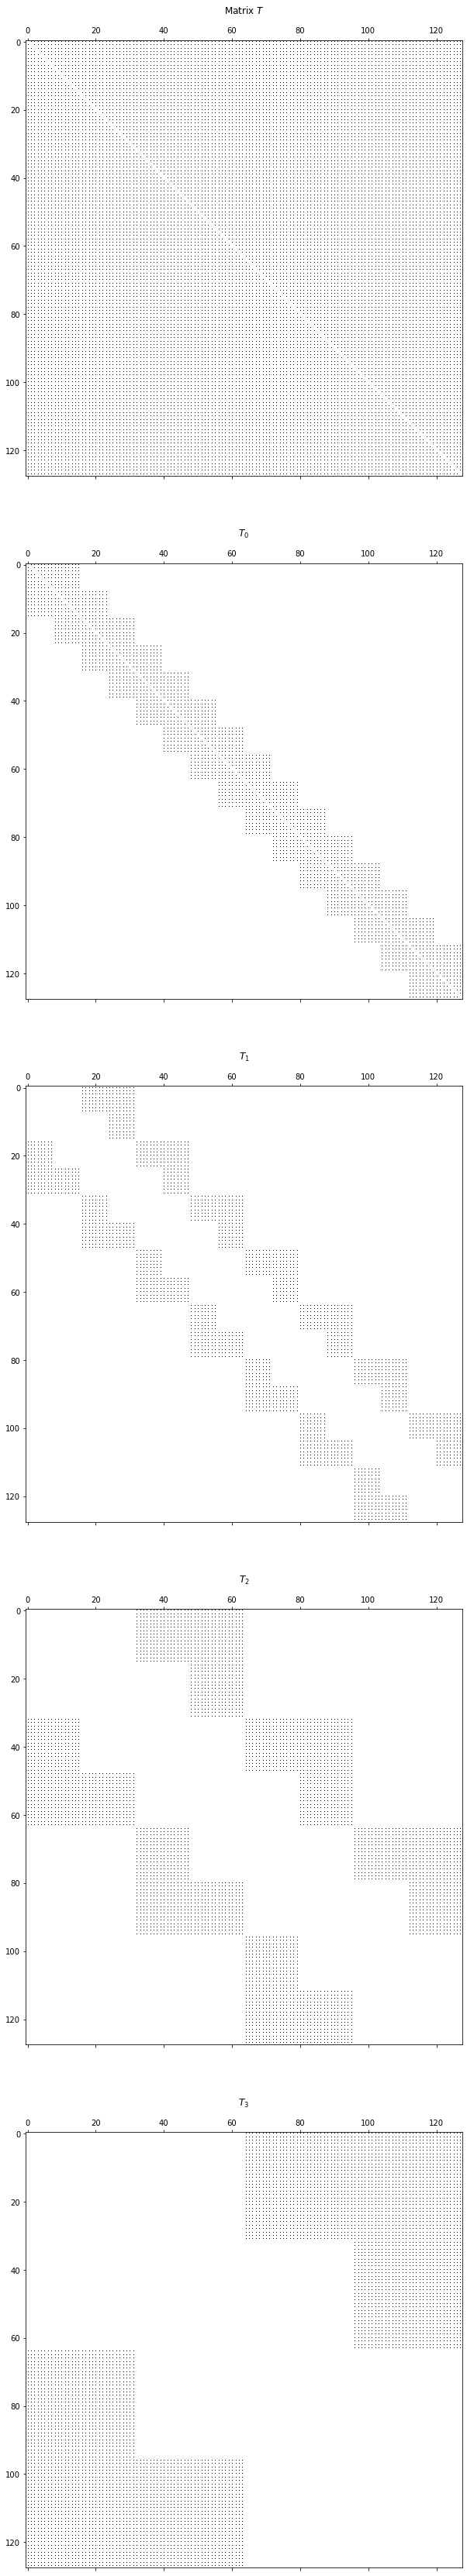

In [17]:
n, k, l = 128, 4, 5
xs = [ k/(n+1) for k in range(1,n+1) ]
K = lambda x,t : np.log(np.abs(x-t))

T = trapezoidal_matrix(xs, K)
sub_Ts = submatrices_T(T, k, l)

len_Ts = len(sub_Ts) + 1

##################### PLOT ###################################

fig = plt.figure('T_matrices', figsize=(len_Ts*12, len_Ts*12))

ax = fig.add_subplot(len_Ts, 1, 1)

ax.set_title('Matrix $T$')
ax.spy(T, marker=',', color='black')

for row,sub_T in enumerate(sub_Ts, 2):
    ax = fig.add_subplot(len_Ts, 1, row)
    
    ax.set_title('$T_{}$'.format(row-2))
    ax.spy(sub_T, marker=',', color='black')
    
plt.show()

<h2 style="text-align: center; font-weight: bold;">Step 5.</h2>

Extract the matrices $P''$ (Eq. (4.19)) from $U_1, U_2U_1, \dots, U_l \dots U_1$ and compute $W_0, \dots, W_{l-2}$ according to Eqs. (4.20).

__Alexandre Comment:__

To achieve my objective I had to understand that all $U$ matrices were exchanged by its corresponding $P''$.

In [18]:
def unprojection_matrices (Us, n, k):
    """Compute the matrices P'' """
    return [
        sparse.csr_matrix([
            [ U[n-k+i,(j+1)*n//k-1] for j in range(k) ] 
            for i in range(k)
        ]) 
        for U in Us
    ]

def dot_product (X, Y):
    return X @ Y

def transformed_matrices (Vs, Ps, n, k):
    """Compute the matrices W """
    I = sparse.eye(n)
    Ws = []
    
    for m,V in enumerate(Vs):
        P_prod = reduce( dot_product, Ps[m:-1:-1], I )
        Ws.append( P_prod @ V @ P_prod.transpose() )
    
    return Ws

<h2 style="text-align: center; font-weight: bold;">Step 6.</h2>

Compute $R_0, \dots, R_l$ by Eq. (4.21), discarding elements below a threshold $\tau$ determined by the precision $\varepsilon$ (Eq. (4.22))

__Alexandre Comment:__

I'll have to exchange $U$ for $P''$ here too.

### Threshold, precision and norm

What is the precision? Why the matrix entries below the precision aren't automatically neglected?

#### Possible answer

The choosen norm is the row-sum norm, defined by the following formula:

$$\lVert M \rVert := \max_i{\sum_{j=1}^{n} \lvert M_{ij} \rvert }$$

It makes this norm somewhat representative of a row of the matrix $M$. The division by $n$ - the number of elements in a row - makes up for this and the quocient $\frac{\lVert M \rVert}{n}$ now is somewhat representative of an element of M.

The last part is the precision $\epsilon$, it may be multiplied by the representative of the element of the matrix as is the logic of the floating point standard.

In [ ]:
def apply_threshold (M, precision):
    '''Implementation of the thresholding of a sparse matrix'''
    rows, cols = M.shape
    assert rows == cols
    
    threshold = precision/n * sparse_linalg.norm(M, ord=float('inf'))
    
    return (M > threshold) * M

In [ ]:
def compute_R (Ws, Ps, l):
    Ws_adapted = Ws + [0,0]
    R = Ws_adapted[0]
    
    for i,P in enumerate(Ps,1):
        R_prev = R
        W = Ws_adapted[i]
        R = P @ R_prev @ P.transpose() + W
    
    return R

## **Procedure to compute** $UT^{-1}U^T$

**Comment** \[Input to this procedure consists of n the matrix $R_l$ which approximates $UTU^T$, and the precision $\varepsilon$. Output is a matrix $X_m$ that approximates $UT^{-1}U^T$.\]

<h2 style="text-align: center; font-weight: bold;">Step 7.</h2>

Compute the matrix $\displaystyle X_0 = \frac{R^T_l R_l}{\lVert R^T_l R_l \rVert}$ by direct matrix multiplication, discarding elements below a threshold $\tau$ determined by the precision $\varepsilon$ (Eq. (4.22))

In [ ]:
def compute_X0 (R, precision):
    RTR = R.transpose() @ R
    norm_RTR = sparse_linalg.norm(RTR, ord=float('inf'))
    
    return apply_threshold(RTR / norm_RTR, precision)

<h2 style="text-align: center; font-weight: bold;">Step 8.</h2>

**Comment** \[Obtain the inverse by Schulz iteration.\]

```
do m = 0, 1, ... while ||I - X_m R_l|| > epsilon
    Compute X_m+1 = 2 X_m - X_m R_l X_m, discarding elements below threshold
enddo
```

In [20]:
class BasisMatricesTestClass (unittest.TestCase):
    def setUp (self):
        self.n, self.k, self.l = 32, 4, 3
        xs = np.linspace(0, 1, self.n)
        
        M_1s = shifted_scaled_matrices(xs, self.k, self.l)
        
        U_j_is_ = orth_moments_matrices_builder(xs, self.k)
        U_j_is = U_j_is_(M_1s)
        
        Us_ = basis_matrices_builder(self.n, self.k, self.l)
        self.Us = Us_(U_j_is)
    
    def test_U_i_js_are_orthogonal (self):
        I = np.eye(2*self.k)
        for U_j in U_j_is:
            for U in U_j:
                self.assertTrue( np.allclose(U.T @ U, I) and np.allclose(U @ U.T, I) )

In [21]:
suite = unittest.TestLoader().loadTestsFromTestCase(BasisMatricesTestClass)
unittest.TextTestRunner(verbosity=4, stream=sys.stderr).run(suite)

test_U_i_js_are_orthogonal (__main__.BasisMatricesTestClass) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.013s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>